# Topics in Applied Optimization (IIIT, Hyderabad, India)
# Jupyter Notebook Assignment-3 
### Instructor: Dr. Pawan Kumar (IIIT, H) (https://faculty.iiit.ac.in/~pawan.kumar/)
If you are not familiar with Jupyter notebook, before proceeding further, please go and watch this video:

https://www.youtube.com/watch?v=HW29067qVWk

## Regarding assignments
### Deadline: 13 October 2019 (or 20 Oct with 15% penalty)
- all the assignment is to be done in this notbook itself
- any proof etc can be done on paper, and image is to be inserted in this notebook
- save this notebook with your roll number and upload it in moodle
- basic familiarity with python is required, brush up if necessary
- you are not allowed to use any existing library for gradient methods; this defeats the purpose of this assignment
- sample output is in the zip file of assignment
- if there are any doubt, then raise it in course moodle site, it may help others
- if you find typo, raise this issue in moodle promptly!
- please avoid copying from others, there may be oral exam to test your knowledge

# Implementation of Recommender System Using Latent Factor Model in Python

Please refer to the class slides for more detail. Also, for full detail, please refer the following main reference:

**[1] Y. Koren, R. Bell, and C. Volinsky, Matrix Factorization Techniques for Recommender Systems, Computer Archive, Volume 42, Issue 8, 2009** 

We first load the necessary libraries: 
1. matplotlib: needed for plotting figures and 
2. numpy needed for doing math

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Now we write the main functions

We write everything inside a class LF, which stands for latent factor. We need the following functions:
1. main
2. train
3. mse
4. sgd
5. predict
6. full_matrix

# Short Tutorial on Recommender Systems
Please see lecture slides for more detail.

## Latent Factor Model
In a recommender systems, we are given an incomplete ratings matrix say R. The $(i,j)$ entry of this matrix is denoted by $r_{ij}.$ 
- We believe that there are dependencies in the matrix, i.e., the matrix is low rank, hence it can be written as a product of low rank matrices. 
- Even if the matrix is not strictly low rank, we believe that certain features are more important than others. In other words, if the ratings matrix were full, then after doing SVD, we get 
$$R = U S V^T$$
some of the singular values were very small, hence the matrix can be approximated well with truncated SVD. Let us consider the first $k$ largest singular vectors, then the truncated SVD is 
$$R \approx U_k S_k V_k.$$
- See IPSC notes for more detail on how to compute SVD or truncated SVD
- For a recomendation problem, for example, movie recomendation or news recommendation or product recommendation, etc, we believe that certain latent features are most important and play a major role in ratings.
- For movie recommendation, for example, latent factors could be comedy, adventure, horror, etc. These features are called latent, because the given data, which is ratings matrix does not explicitely tells about these.
- For recommendation systems, we cannot do SVD, because the matrix $R$ is incomplete! Obviously, we cant treat the missing entries to be zero! Hence, instead of doing SVD, we will consider an error function that consider only the ratings that are given. Let us assume that the ratings matrix can be modelled as a latent factors, i.e., suppose that $$R = PQ, \quad P \in \mathbb{R}^{n \times k}, Q \in \mathbb{R}^{k \times n},$$ then the given rating $$r_{ij} = p_{i*}q_{*j},$$ where $p_{i*}$ denotes the $i$th row of $P,$ and $q_{*j}$ denotes the $j$th column of $Q.$


## Optimization Model
- As mentioned above, we cannot directly do SVD, however, we can indeed create a **loss function** as follows:
$$\mathcal{L}(p_{1*}, p_{2*}, \dots p_{n*}, q_{*1}, q_{*2}, \dots, q_{*n}) = \sum_{(i,j) \in K} (r_{ij} - p_{i*}q_{*j}).$$
- Note above that we see loss function as a function the variables $p_{1*}, p_{2*}, \dots, p_{*n},$ which are row vectors of $P,$ and as the column vectors of $Q,$ which are $q_{*1}, q_{*2}, \dots, q_{*n}.$ This allows us to **vectorize**. Why vectorize?
- In machine learning the weights and their combinations with the given data creates a model. In this case, the model is $PQ.$ Since the $k,$ is a hyperparameter, it is likely that one may choose $P$ and $Q$ to have too many columns, i.e., too many weights are used, this will lead to a large model, and hence leading to **overfitting**. 
If you are not familiar with overfitting, then pause here, and see the video here:

https://www.youtube.com/watch?v=u73PU6Qwl1I

    - What did you learn from video? 
    - What is termed as model? 
    - What is the meaning of model being large? 
    - What is the difference between linear and logistic regression? 
    - What is underfitting? 
    - What is a bias? 
    - How do you characterize bias and variance using terms overfitting or underfitting?

- A well known way to avoid overfitting is to do regularizations, by penalizing **large model** size. Let us modify our loss function as follows:
$$\mathcal{L}(\cdot) = \sum_{(i,j) \in K} (r_{ij} - p_{i*}q_{*j})^2 + \gamma/2 (\| P \|_F^2 + \| Q \|_F^2)$$
    - We have added the term $\gamma/2(\| P \|_F^2 + \| Q \|_F^2).$ It is called **regularization term**
    - The parameter $\gamma$ is called the **regularization parameter**
    - High $\gamma$ would mean that we don't want big model size; this may help prevent overfitting
- Let $e_{ij}$ denote the error corresponding to each $(ij)$ term, 
$$e_{ij} = r_{ij} - \sum_{s=1}^k p_{is}q_{sj}$$
then let us define the new error term $\tilde{e}$
$$\tilde{e}_{ij} = e_{ij}^2 + \gamma/2 (\|P\|_F^2 + \| Q \|_F^2),$$ 
that is,
$$\tilde{e}_{ij} = (r_{ij} - \sum_{s=1}^k p_{is}q_{sj} )^2 + \gamma/2 (\|P\|_F^2 + \| Q \|_F^2)$$
- Note that $$\mathcal{L}(\cdot) = \sum_{(i,j) \in \mathcal{K}} \tilde{e}_{ij},$$
where $\mathcal{K}$ is the set of all indices for which ratings $r_{ij}$ are available.


## Gradient Method Versus Stochastic Gradient Methods
Following notes are taken from 
https://en.wikipedia.org/wiki/Stochastic_gradient_descent

For large dataset, $k$ and $n$ tend to be large, and computing gradient fully becomes too demanding. In machine learning or statistical estimation, we are usually required to find minimum of the loss functions of the form 
$$Q(w) = 1/n \sum_{j=1}^n Q_j (w)$$
That is loss function as "additive" decomposition. In other words, the loss function is a sum of the loss function where the sum is over the data samples. If $n$ is large, then computing full gradient is computationally demanding. However, if we indeed decide to run the gradient method. Then we recall the following steps:
1. Take initial random weight (possibly random and normally distributed between 0 and 1): $w^0$
2. $w^{i+1} = w^i - \alpha \nabla Q(w^i), \quad i=0, \dots$

Here the gradient $\nabla Q$ is the full gradient in the sense that
\begin{align}
\nabla Q(w) = \sum_{i=1}^n \nabla_{w}Q_i(w). \label{grad} \tag{1}
\end{align}

Here
\begin{align}
\nabla_w Q_i (w) = \begin{bmatrix}
\dfrac{\partial Q_i (w)}{\partial w_1} \\
\dfrac{\partial Q_i (w)}{\partial w_1} \\
\vdots \\
\dfrac{\partial Q_i (w)}{\partial w_n} \\
\end{bmatrix}  \label{grad2} \tag{2}
\end{align}

### Stochastic gradient  descent method
Stochastic gradient merthod, in short, SGD is a method (not necessarily descent due to stochasticity, but in expectation is usually is a descent), where the gradient is computed partially. For example, instead of summing for all $i=1...n,$ we can take a random sample, say $j_1,$ and do the update only for this sample as follows:
$$\nabla Q(w) = \nabla_{w}Q_{j_1}(w),$$
that is we have picked just one of the term i.e., $j_1$th term from \eqref{grad}.
Then the SGD update is:
$$w^{i+1} = w^i - \alpha \nabla Q_{j_1}(w^i), \quad i=0, \dots$$
Note that we could have taken few more terms in the sum, and would have updated for a batch. This is called, batched stochastic gradient descent.
It sounds incorrect, isnt it? Why such method may converge? With some basic assumption on the loss function, we can prove some convergence in expectance. More on convergence theory in class!

$\color{red}{\text{Question-0:}}$ Compute the full gradient of the loss function for recommendation system

$\color{red}{\text{Answer:}}$  
## Please find the answer in attached pdf


In the following, we derive a stochastic gradient for the loss function for recommender loss.

## Gradient Method for Optimization Problem
- We want to use gradient method to minimize the error. An update in gradient method is given as follows
$$w^{i+1} = w^i - \nabla \mathcal{L}(w^i)$$
- To use gradient method, we need to compute gradient. If we see $\mathcal{L}$ as a function of $p_{ik}'$s and $q_{ki}'$s, then 
$$\dfrac{\partial \mathcal{L}}{\partial p_{is}} = 2e_{is} \dfrac{\partial e_{is}}{\partial p_{is}} + \gamma p_{is} = -2e_{is} q_{sj} + \gamma p_{is}$$
Similarly,
$$\dfrac{\partial \mathcal{L}}{\partial q_{sj}} = 2e_{sj} \dfrac{\partial e_{sj}}{\partial q_{sj}}+\gamma q_{sj} = -2e_{sj}p_{js} + \gamma q_{sj},$$
- The gradient vector $\nabla \mathcal{L}$ is given by
$$\nabla \mathcal{L} = \left(\dfrac{\partial \mathcal{L}}{\partial p_{11}}, \dots, \dfrac{\partial \mathcal{L}}{\partial p_{nk}}, \dfrac{\partial \mathcal{L}}{\partial q_{11}}, \dots, \dfrac{\partial \mathcal{L}}{\partial p_{kn}} \right)$$
- The weights $p_{is}$ can be updated as
$$p_{is} = p_{is} + \alpha (2e_{ij} q_{sj} - \gamma p_{is}) $$
- The weights $p_{sj}$ can be updated as
$$q_{sj} = q_{sj} + \alpha (2e_{ij} p_{js} - \gamma q_{sj}) $$
- We can vectorize $s.$ Finally, the vectorized form of the update looks like:
$$(p_{i+1*}, q_{*j+1})^T = (p_{i*}, q_{*j})^T + \alpha ((2e_{ij} q_{*j} - \gamma p_{i*}), (2e_{ij} p_{j*} - \gamma q_{*j}))^T  $$
- The error at $(p_{i*}, q_{*j})^T$ nedded above can be computed by $$e_{ij} =  r_{ij} - \text{prediction at}~ (i,j) $$
Here prediction at $(i,j)$ can be computed by making a call to predict() function below.

$\color{red}{\text{Question-1:}}$ Why the error is computed this way?

$\color{red}{\text{Answer:}}$ Either use latex (preferred) or write it on paper, take pic, and insert it here. See the video on jupyter above on how to paste images.

##  ** please find the answer in attached pdf**


$\color{red}{\text{Question-2:}}$ Are the updates for $p_{i*}$ and $q_{*j}$ stochastic? Justify.

$\color{red}{\text{Answer:}}$ 

Yes the updates for $p_{i*}$ and $q_{*j}$ are stochastic as they are getting updated after every<br> training sample. As the rating in one cell is given by a product of a whole row from P , i.e.$P_{i*}$ and a whole column<br> from Q, i.e. $Q_{*j}$, the update of one sample updates the weights of whole row and column in P and Q respectively. The gradient of loss function of a single term , i.e. $e_{ij}$ updates the entire row and column in P and Q. 
##  ** please find the rest of the answer in attached pdf **

# Adding Bias
It is often observed in practice that adding a bias term helps. Let us add the bias term $b$ to the prediction function. The bias term is computed as the mean of the ratings matrix. See the predict function below to see how bias is added.

$\color{red}{\text{Question-2b:}}$ Read the main reference paper and justify why bias is added. Note in this notebook we add global bias. Which other bias term was suggested in the paper?

$\color{red}{\text{Answer:}}$

1. The purpose of adding bias is to keep a balance between overfitting and underfitting. The model's variance can be<br> changed by adding bias. The purpose for adding a bias value is to fit the data better. There can be a possibility that model would hyper personalise the rating for the user and lead to overfiiting. So, it would only provide correct results for people in the training set and would lead to inaccurate results in new data. variance van't be decreased without increasing the bias. So, in order to make the model more general such that it works for all kind of data, bias needs to be added.

2. The other bias terms that were suggested in the paper were:

 The observed
variation in rating values is due to effects associated with
either users or items, known as biases or intercepts, independent of any interactions. For example, typical collaborative
filtering data exhibits large systematic tendencies for some
users to give higher ratings than others, and for some items
to receive higher ratings than others. After all, some products
are widely perceived as better (or worse) than others. The other bias terms are $ b_i $ and $ b_u $ which are item and user bias respectively apart from the bias already defined which is , u, i.e. global average.

<center> So, $ r_{ui}  = b_i + b_u + q_i^Tp_u + u $ </center>

<center> $ b_i $ denotes the item bias which is the value by which average rating of an item differs from other items </center>
<center> $ b_u $ denotes the user bias which is the value by which average rating of a user differs from other users </center>
<center> u is the average rating from the entire matrix </center>
<center> $ r_{ui} $ is the predicted rating. </center>

    





In [63]:
class LF(): 
    
    def __init__(self, R, K, alpha, gamma, iterations):
        """
        Parameters:
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - gamma (float)  : regularization parameter
        """
        
        self.R = R
        self.num_users, self.num_items = R.shape
        print(self.num_items)
        self.K = K
        self.alpha = alpha
        self.gamma = gamma
        self.iterations = iterations
#         j=1
#         b_i=np.mean(self.R.T[j][np.where(self.R.T[j]!=0)])
#         b_u=np.mean(self.R[i][np.where(self.R[i] != 0)])
#         print(self.R[np.where(self.R[:,j]!=0)
#         print(b_i)

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
        
        # Compute the global bias
        # For Question-6, you may want to initialize additional bias terms here
        self.b = np.mean(self.R[np.where(self.R != 0)])
#         self.b=0
        #self.b_i = TODO 
        #self.b_u = TODO
        
        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]
#         print(self.samples)
        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("SGD Iteration: %d ; error = %.4f" % (i+1, mse))
        
        return training_process

    def mse(self):
        """
        MSE: Compute Mean Square Error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
            error+=((self.gamma)/2)*(np.sum(np.square(self.P[x]))+np.sum(np.square(self.Q[y])))
#         print(error)
        return np.sqrt(error)

    def sgd(self):
        """
        SGD: Stochastic Graident Descent
        """
        for i, j, r in self.samples:
            # Compute prediction and error
            prediction = self.predict(i,j)
            e = self.R[i,j]-prediction
            
            # Keep a copy of row of P. It will be needed for update
            P_i = self.P[i, :]
            Q_j= self.Q[j,:]
            self.P[i, :] = np.add(P_i,self.alpha*2*e*Q_j-self.alpha*self.gamma*P_i)
            self.Q[j, :] = np.add(Q_j,self.alpha*2*e*P_i-self.alpha*self.gamma*Q_j)
            
            
    def gd(self):
        """
        GD: Graident Descent
        Replace self.sample below to full batch for gradient descent
        Feel free to remove everything, and implement from scratch
        """
        change_p=np.zeros((self.num_users,self.K))
        change_q=np.zeros((self.num_items,self.K))
        for i, j, r in self.samples:
            # Compute prediction and error
            prediction = self.predict(i,j)
            e = self.R[i,j]-prediction
            
            # Create copy of row of P since we need to update it but use older values for update on Q
            P_i = self.P[i, :]
            Q_j= self.Q[j,:]
            
            # Update user and item latent feature matrices
            change_p[i, :] = np.add(change_p[i,:],self.alpha*2*e*Q_j-self.alpha*self.gamma*P_i)
            change_q[j, :] = np.add(change_q[j,:],self.alpha*2*e*P_i-self.alpha*self.gamma*Q_j)
        np.multiply(change_p,(1/len(self.samples)))
        np.multiply(change_q,(1/len(self.samples)))
        self.P=np.add(self.P,change_p)
        self.Q=np.add(self.Q,change_q)
    
            

    def predict(self, i, j):
        """
        Prediction: Predicted the rating of user i and item j
        """
        prediction = self.b + self.P[i, :].dot(self.Q[j, :].T)

        return prediction
    
    def full_matrix(self):
        """
        The rating matrix using the biases P and Q
        """
        return self.b + self.P.dot(self.Q.T)


In [59]:
R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])
lf = LF(R, K=2, alpha=0.01, gamma=0.001, iterations=50)
training_process = lf.train()
print()
print("P x Q:")
print(lf.full_matrix())
print()
print("Global bias:")
print(lf.b)
print()

4
SGD Iteration: 10 ; error = 4.2185
SGD Iteration: 20 ; error = 2.1467
SGD Iteration: 30 ; error = 1.5079
SGD Iteration: 40 ; error = 1.2384
SGD Iteration: 50 ; error = 1.0365

P x Q:
[[4.83515828 3.40481059 1.48761974 1.13283659]
 [4.16447545 4.04156284 1.30044502 1.32705947]
 [0.8006628  1.12910623 4.73063718 4.74203847]
 [1.00405832 2.61564184 3.58560119 4.01171616]
 [0.90934326 1.20189342 4.63505998 4.64022357]]

Global bias:
2.769230769230769



# More questions

$\color{red}{\text{Question-3:}}$ Implement the full gradient descent method

$\color{red}{\text{Answer:}}$ Complete gd function above

## completed in the code above 

$\color{red}{\text{Question-4:}}$ Vectorize the updates of p and q, by vectorizing s (detailed above)

$\color{red}{\text{Answer:}}$ Fill the TODO in code above
## completed in the code above

### Using the code below, answer the following:

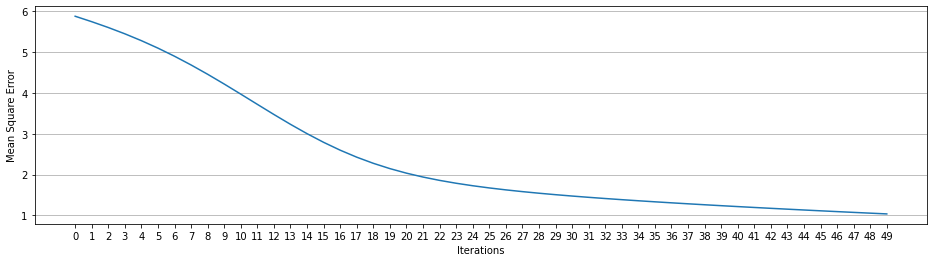

In [60]:
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")

$\color{red}{\text{Question-5:}}$ Plot the MSE versus iterations for $\alpha=1, \gamma=0.01$ and 100 iterations of SGD

$\color{red}{\text{Answer:}}$ Put your figure here

## **Find the graph in pdf and separately in the directory**



$\color{red}{\text{Question-6:}}$ Show the plot for 50 iterations, $\alpha=1, \gamma=0.01$ of SGD without bias, i.e., $b=0$

$\color{red}{\text{Answer:}}$ Paste your output and figures here or below this cell
## Find the graph in pdf and separately in the directory


$\color{red}{\text{Question-7:}}$ Repeat above with bias

$\color{red}{\text{Answer:}}$ Paste your output and figures here or below this cell

## Find the graph in pdf and separately in the directory


$\color{red}{\text{Question-8:}}$ Show plots with values of regularization parameters to be 1, 0.1, 0.01, 0.001 and for 50 iterations, and $\alpha=1, \gamma=0.01$

$\color{red}{\text{Answer:}}$ Paste all your plots here or below this cell.
## Find the graph in pdf and separately in the directory



$\color{red}{\text{Question-9:}}$ Prove that the loss function is not convex. Is the loss function differentiable?

$\color{red}{\text{Answer:}}$ Write your answer here.
## Find the answer in pdf and separately in the directory


## Bonus Question

$\color{red}{\text{Question-10:}}$ In the reference paper [1] above, additional bias terms are recommended, implement it

$\color{red}{\text{Answer:}}$ Put your modified function here or below this cell.

In [ ]:
# These functions can be replaced with the functions present in the above class

    def predict(self, i, j):
            """
            Prediction: Predicted the rating of user i and item j
            """
            b_u=np.mean(self.R[i][np.where(self.R[i] != 0)])
            b_i=np.mean(self.R.T[j][np.where(self.R.T[j]!=0)])
            prediction = self.b + self.P[i, :].dot(self.Q[j, :].T)+(b_u-self.b)+(b_i-self.b)

            return prediction
    
    def full_matrix(self):
        """
        The rating matrix using the biases P and Q
        """
        new_values=np.zeros((self.R.shape[0],self.R.shape[1]))
        for i in range(R.shape[0]):
            for j in range(R.shape[1]):
                b_u=np.mean(self.R[i][np.where(self.R[i] != 0)])
                b_i=np.mean(self.R.T[j][np.where(self.R.T[j]!=0)])
                new_values[i][j]=self.b+(b_u-self.b)+(b_i-self.b)
        return new_values + self.P.dot(self.Q.T)

$\color{red}{\text{Question-11:}}$ Download the netflix ratings matrix, and run your algorithm.

$\color{red}{\text{Answer:}}$ Put your MSE versus iterations here.

1000
SGD Iteration: 10 ; error = 61.3745
SGD Iteration: 20 ; error = 56.0818
SGD Iteration: 30 ; error = 51.2782
SGD Iteration: 40 ; error = 47.7073
SGD Iteration: 50 ; error = 45.1576
SGD Iteration: 60 ; error = 43.1596
SGD Iteration: 70 ; error = 41.6426
SGD Iteration: 80 ; error = 40.5469
SGD Iteration: 90 ; error = 39.7352
SGD Iteration: 100 ; error = 39.1547

P x Q:
[[2.86552247 3.10958073 4.43513636 ... 3.17506707 3.63346127 2.76967231]
 [3.50213643 2.90193726 4.09270524 ... 3.69447386 4.06737624 3.51821315]
 [3.24794478 3.08814539 4.18130004 ... 3.46544326 3.82633837 3.21392298]
 ...
 [3.5164263  3.41672043 3.84297678 ... 3.59732366 3.73627404 3.50782307]
 [3.30109185 4.28297914 3.58788608 ... 3.25488964 3.06717803 3.21295843]
 [3.54728283 3.08855718 3.97460169 ... 3.68913208 3.96603179 3.5607568 ]]

Global bias:
3.6463483146067417



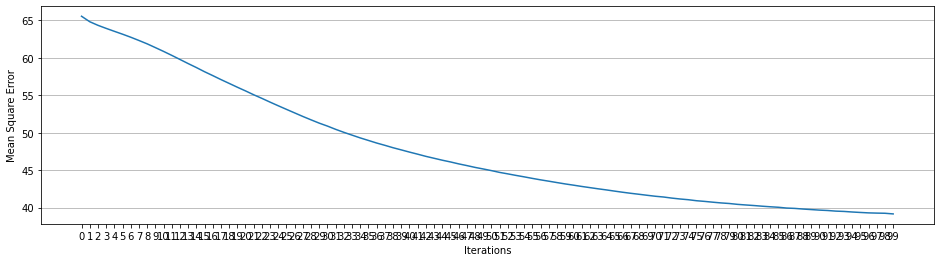

In [64]:
import numpy as np
with open('./combined_data_1.txt') as f:
    i=0
    arr=np.zeros((10000,1000))
    x=0
    while i<1000000:
        i+=1
        lines=f.readline()
        line=lines.split(',')
        if len(line)>1:
#             print(line[1])
            if (int)(line[0])<10000:
                arr[(int)(line[0])][x]=(int)(line[1])
        else:
            x+=1
    lf = LF(arr, K=2, alpha=0.01, gamma=0.001, iterations=100)
    training_process = lf.train()
    print()
    print("P x Q:")
    print(lf.full_matrix())
    print()
    print("Global bias:")
    print(lf.b)
    print()
    x = [x for x, y in training_process]
    y = [y for x, y in training_process]
    plt.figure(figsize=((16,4)))
    plt.plot(x, y)
    plt.xticks(x, x)
    plt.xlabel("Iterations")
    plt.ylabel("Mean Square Error")
    plt.grid(axis="y")
    

## Thats All Folks! Further Readings or Infomation 
https://www.coursera.org/learn/networks-illustrated/lecture/8GPZT/netflix-timeline

# Keep Recommending!